### USING MACHINE LEARNING AND DEEP LEARNING TO MODEL SINGAPORE HDB FLAT RESALE PRICES
In Singapore, public housing flats are provided by a government body called the Housing Development Board (HDB). These flats have a 99-year lease starting from the year they are released for tenant occupation. After a Minimum Occupation Period (MOP) of typically 5 years, the flat owner has the option to sell it on the resale market.

This notebook attempts to create a suitable model (via machine learning and deep learning) that can reasonably approximate the relationship between the various features of a HDB resale flat (resale transaction month, flat type etc.) and the target variable, the resale price.

### DATA SOURCE
For the data source, we will use a total of five CSV files available from the **data.gov.sg** website:

<a href="https://data.gov.sg/collections/189/view" target="_blank">HDB Resale Flat Prices</a>

As indicated on the above webpage:
>Resale transacted prices. Prior to March 2012, data is based on date of approval for the resale transactions.<br>
For March 2012 onwards, the data is based on date of registration for the resale transactions.

For our purposes, we will treat the approval and registration dates as one and the same, as the effective date of the resale transaction.

The five CSV files are named as such:

1. Resale Flat Prices (Based on Approval Date), 1990 - 1999
2. Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012
3. Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016
4. Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014
5. Resale flat prices based on registration date from Jan-2017 onwards

*NB: The last file, for the purposes of this notebook, will contain data until the end of Oct 2024.*

For clarity and consistency, I have renamed the files as follows and placed them in the 'data' folder of the Github repository:

1. 1_resale_flat_prices_1990_1999
2. 2_resale_flat_prices_2000_to_feb2012
3. 3_resale_flat_prices_mar2012_to_dec2014
4. 4_resale_flat_prices_jan2015_to_dec2016
5. 5_resale_flat_prices_jan2017_to_oct2024

### OVERVIEW OF THE DATA TYPES IN THE DATA SOURCE
**month:** [ordinal data]<br>
 Four-digit year followed by a two-digit month, separated by a hyphen '-' (for e.g. 1990-01).<br>Based on the Approval Date or the Registration Date of the resale transaction. We will treat both types of dates as the effective date of the resale transaction.<br><br>
**town:** [nominal data]<br>
Town names include 'ANG MO KIO', 'PASIR RIS' etc.<br><br>
**flat_type:** [nominal data]<br>
The data from '1 ROOM' to '5 ROOM' can be considered ordinal (the floor areas of the flat typically increase with more rooms). But due to the presence of other values like 'EXECUTIVE' and 'MULTI-GENERATION' which can have similar floor areas, this feature will be treated as nominal data instead.<br><br>
**block:** [nominal data]<br>
The block number of the building, which may include an alphabetic suffix.<br><br>
**street_name:** [nominal data]<br>
Note that there are abbreviations used in this feature ('ST' for 'Street', 'AVE' for 'Avenue' etc.). The abbreviations are consistent and standardised across the five CSV files.<br><br>
**storey_range:** [ordinal data]<br>
This is notated in "bins" of three storeys each. For e.g. '01 TO 03', '04 TO 06' etc.<br><br>
**floor_area_sqm:** [continuous data]<br>
The floor area of the flat in $m^2$.<br><br>
**flat_model:** [nominal data]<br>
This can probably be thought of as the "design style/philosophy" for the flat. A flat model may apply to more than one flat type.<br><br>
**lease_commence_date:** [ordinal data]<br>
Four-digit **year** indicating when the flat was officially released for tenant occupation.<br><br>
**remaining_lease:** [ordinal data]<br>
As all HDB flats have a 99-year lease, the remaining lease can be calculated this way:

&emsp;&emsp;remaining_lease = 99 - (current_year - lease_commence_date)

*NB: This feature is only found in the last two CSV files of the data source:<br>'4_resale_flat_prices_jan2015_to_dec2016.csv' and '5_resale_flat_prices_jan2017_to_oct2024.csv'*

This feature will be dropped after importing the data, as its value is dependent on the current year.*<br><br>
**resale_price**: [continuous data]<br>
In Singapore Dollars (S$), at the point of the resale transaction. The prices have not been adjusted for inflation.

### IMPORT PYTHON LIBRARIES
We will use Python 3.x to create our models.

All Python libraries used will be listed in this section for ease of reference.

In [2]:
# For data manipulation
import numpy as np
import pandas as pd

# To convert string information into numerical representation
from sklearn.preprocessing import LabelEncoder

# For data standardisation
from sklearn.preprocessing import StandardScaler

# For visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# For shuffling datasets
from sklearn.utils import shuffle

# For Support Vector Regression
from sklearn.svm import SVR

# For Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# For Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

# For splitting the dataset into Train and Test sets
from sklearn.model_selection import train_test_split

# For generating metrics to measure how well the models perform
from sklearn.metrics import mean_absolute_error, r2_score

# To suppress INFO messages from tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# We will use Keras/Tensorflow for deep learning
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import R2Score

# Libraries needed to reset the random seed in tensorflow
import random
import tensorflow as tf
import random as python_random


# DEFINE SOME GLOBAL CONSTANT VALUES ===========================================

# This random seed list will be used to verify the consistency of training
# results in the deep learning models, when using datasets that have been
# shuffled/split differently based on the random seed used
random_seed_list = [123, 2024]

# The first of those random seed values is used as a fixed random seed to
# ensure reproducibility of results in the machine learning models
random_seed = random_seed_list[0]

# For brevity and faster performance, we will restrict our analysis
# to only '3 ROOM' flat types
selected_flat_type = '3 ROOM'

### PROCESS THE DATA
1. IMPORT AND CONSOLIDATE THE DATA<br>
We load the five HDB CSV files into a dataframe and check for any missing entries.<br><br>
2. FEATURE ENGINNEERING / DATA PREPROCESSING<br>
Next, we tidy up the data and encode string fields into numerical format to facilitate processing downstream.

In [3]:
# 1. IMPORT AND CONSOLIDATE THE DATA ===========================================

# Path of the folder that contains the HDB data files in csv format
data_dir = 'https://raw.githubusercontent.com/prog4321/' + \
    'hdb_resale/refs/heads/main/data/'

csv_dataset_group1 = ['1_resale_flat_prices_1990_1999.csv',
                    '2_resale_flat_prices_2000_to_feb2012.csv',
                    '3_resale_flat_prices_mar2012_to_dec2014.csv']

# The files in this group contain a 'remaining_lease' feature that
# we need to remove later on
csv_dataset_group2 = ['4_resale_flat_prices_jan2015_to_dec2016.csv',
                    '5_resale_flat_prices_jan2017_to_oct2024.csv']


# Concatenate the datasets in 'group1'
ctr = 0
for csv_dataset in csv_dataset_group1:
    if ctr == 0:
        df_group1 = pd.read_csv(r'' + data_dir + csv_dataset)
    else:
        df_temp = pd.read_csv(r'' + data_dir + csv_dataset)
        df_group1 = pd.concat([df_group1, df_temp], ignore_index=True)
    ctr += 1

# Concatenate the datasets in 'group2'
ctr = 0
for csv_dataset in csv_dataset_group2:
    if ctr == 0:
        df_group2 = pd.read_csv(r'' + data_dir + csv_dataset)
    else:
        df_temp = pd.read_csv(r'' + data_dir + csv_dataset)
        df_group2 = pd.concat([df_group2, df_temp], ignore_index=True)
    ctr += 1


# Drop the 'remaining_lease' feature that is only found in group2
df_group2 = df_group2.drop(['remaining_lease'], axis=1)


# Concatenate the 2 datasets
df_full = pd.concat([df_group1, df_group2], ignore_index=True)


# Set the display to include all columns in the dataframe
pd.set_option('display.max_columns', None)


# Quick visual check of the data to ensure it is OK
print('1st 5 records from dataset:\n\n', df_full.head())
print('\nDataset shape:', df_full.shape)


# Check to see if there is any missing data (NaN values etc.)
print('\nFeatures that have missing information:\n',
        df_full.isnull().sum())


# 2. FEATURE ENGINNEERING / DATA PREPROCESSING =================================

def get_feature_to_index_dict(col_names_list):
    # A convenience function that generates a dictionary which contains the
    # column names and corresponding column indices for easier cross-reference
    feature_names = col_names_list
    enum_feature_names = enumerate(feature_names)
    feature_to_index_dict = dict((feature_name, index) for \
        index, feature_name in enumerate(feature_names))
        # returns a dictionary: {'month': 0, 'town': 1, etc.}

    return feature_to_index_dict


def encode_transaction_month(entry):
    # The transaction month is indicated by the year and the month, separated
    # by a hyphen (for e.g. '1990-01').
    # This function retains the year component of the transaction month.
    # It also divides the month component into 12 equally-spaced units and then
    # adds that value (as a decimal) to the year component.
    # Thus '1990-01' becomes 1990.0, '1990-02' becomes 1990.08,
    # '1990-03' becomes 1990.17 etc.
    year = int(entry[:4]) # Extract first 4 digits
    month = int(entry[-2:]) # Extract last 2 digits
    month = (month - 1) / 12
    month = round(month, 2) # Round to 2 decimal places
    result = year + month
    return result


def decode_transaction_month(entry):
    # Convert 1990.0 back to '1990-01', 1990.08 back to '1990-02' etc.
    year = int(entry) # Extract first 4 digits
    month = entry - year
    month = round(month * 12) + 1

    if month < 10:
        month = '0' + str(month)
    else:
        month = str(month)

    result = str(year) + '-' + month

    return result


def encode_storey_range(entry):
    # The storey range is indicated in "bins" of three storeys each.
    # For e.g. '01 TO 03', '04 TO 06', '07 TO 09' etc.
    # Here, we extract the last 2 digits and divide it by 3.
    # So '01 TO 03' becomes 1, '04 TO 06' becomes 2 etc.
    storey_code = int(entry[-2:]) / 3
    return int(storey_code)


def decode_storey_range(entry):
    # Convert 1 back to '01 TO 03', 2 back to '04 TO 06' etc.
    storey_upper_range = entry * 3
    storey_lower_range = storey_upper_range - 2

    if storey_upper_range < 10:
        storey_upper_range = '0' + str(storey_upper_range)
    else:
        storey_upper_range = str(storey_upper_range)

    if storey_lower_range < 10:
        storey_lower_range = '0' + str(storey_lower_range)
    else:
        storey_lower_range = str(storey_lower_range)

    result = storey_lower_range + ' TO ' + str(storey_upper_range)

    return result


class PreprocessHDBData(object):
    '''To clean and transform the dataset into appropriately
    encoded numerical data'''

    def transform(self, df):

        self.__dframe = df


        # As the block number by itself is quite meaningless, we will
        # combine it with the street name to produce more useful information
        block = self.__dframe['block'].str.upper()
        street_name = self.__dframe['street_name'].str.upper()

        block_and_street_name = block + ' ' + street_name

        self.__dframe.rename(columns = \
            {'street_name':'block_and_street_name'}, inplace = True)
        self.__dframe['block_and_street_name'] = block_and_street_name

        # Drop the original 'block' feature, which is now redundant
        self.__dframe = self.__dframe.drop(['block'], axis=1)


        # We generate a dictionary of the features to their respective
        # indices, for easier and more reliable cross-reference later.
        # This returns a dictionary containing {'month': 0, 'town': 1, etc.}
        self.__feature_to_index_dict = \
            get_feature_to_index_dict(self.__dframe.columns.values.tolist())


        # Divide the resale_price feature by 1,000 for easier visualisation
        self.__dframe.iloc[:, self.__feature_to_index_dict['resale_price']] = \
            self.__dframe['resale_price'] / 1000


        # PROCEED TO ENCODE THE FEATURES SO THAT THE DATAFRAME
        # CONTAINS ONLY NUMERICAL INFORMATION

        # ENCODE AND UPDATE THE MONTH (ORDINAL FEATURE)
        self.__dframe.iloc[:, self.__feature_to_index_dict['month']] = \
            self.__dframe['month'].apply(encode_transaction_month).astype(float)


        # ENCODE AND UPDATE THE TOWN (NOMINAL FEATURE)
        town_encoder = LabelEncoder()
        encoded_town = town_encoder.fit_transform(self.__dframe['town'].values)

        self.__dframe.iloc[:, self.__feature_to_index_dict['town']] = encoded_town


        # ENCODE AND UPDATE THE FLAT TYPE (NOMINAL FEATURE)
        # Standardise the values for 'MULTI-GENERATION' to include the hyphen
        self.__dframe.iloc[:, self.__feature_to_index_dict['flat_type']] = \
            self.__dframe['flat_type'].replace('MULTI GENERATION', 'MULTI-GENERATION')

        self.__flat_type_encoder = LabelEncoder()
        encoded_flat_type = \
            self.__flat_type_encoder.fit_transform(self.__dframe['flat_type']).astype(int)
        self.__dframe.iloc[:, self.__feature_to_index_dict['flat_type']] = \
            encoded_flat_type


        # ENCODE AND UPDATE THE BLOCK AND STREET NAME
        block_and_street_name_encoder = LabelEncoder()
        encoded_block_and_street_name = \
            block_and_street_name_encoder.fit_transform(self.__dframe['block_and_street_name']).astype(int)

        self.__dframe.iloc[:, \
            self.__feature_to_index_dict['block_and_street_name']] = \
            encoded_block_and_street_name


        # ENCODE AND UPDATE THE STOREY RANGE (ORDINAL FEATURE)
        self.__dframe.iloc[:, self.__feature_to_index_dict['storey_range']] = \
            self.__dframe['storey_range'].apply(encode_storey_range).astype(int)


        # ENCODE THE FLAT MODEL
        flat_model = self.__dframe['flat_model'].str.upper()
        flat_model_encoder = LabelEncoder()
        encoded_flat_model = \
            flat_model_encoder.fit_transform(flat_model).astype(int)

        self.__dframe.iloc[:, self.__feature_to_index_dict['flat_model']] = \
            encoded_flat_model


        # SET THE DATA TYPE OF THE LEASE COMMENCE DATE TO FLOAT
        # This is to faciliate the data standardisation process later on
        self.__dframe = self.__dframe.astype({'lease_commence_date': float})


        return self.__dframe


    def flat_type_encoder(self):
        # This function lets us access the flat_type_encoder of the
        # PreprocessHDBData object. We will use this flat_type_encoder later to
        # encode a selected flat type which is given in its original
        # string format, like '3 ROOM' etc. The encoded numerical value is
        # then used to filter to the records in the dataframe that contain
        # the flat type.
        return self.__flat_type_encoder


# END OF `PreprocessHDBData` CLASS =============================================


# Create a new instance of the PreprocessHDBData object and run
# the transform method
preprocess = PreprocessHDBData()
df_full = preprocess.transform(df_full)


# This encoder will allow us to filter to the records that match a
# selected flat type later on
flat_type_encoder = preprocess.flat_type_encoder()


# Do a quick visual check of the dataframe to ensure the data has been encoded
# correctly and is in numerical form
print('\n1st 5 records from ENCODED dataset:\n\n', df_full.head())

1st 5 records from dataset:

      month        town flat_type block       street_name storey_range  \
0  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
1  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     04 TO 06   
2  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
3  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     07 TO 09   
4  1990-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     04 TO 06   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0            31.0        IMPROVED                 1977        9000.0  
1            31.0        IMPROVED                 1977        6000.0  
2            31.0        IMPROVED                 1977        8000.0  
3            31.0        IMPROVED                 1977        6000.0  
4            73.0  NEW GENERATION                 1976       47200.0  

Dataset shape: (939173, 10)

Features that have missing information:
 month                  0
town     

The data looks good - there are no missing entries and the data has been encoded correctly.

### SHUFFLE AND SPLIT DATASET INTO TRAIN AND TEST DATASETS
We shuffle the full dataset before doing a 70/30 Train/Test dataset split.

*Note that we don't use the scikit-learn 'train_test_split' function at this point, as we want to keep the target variable (resale price) in the same dataframe to make it easier to run pairplot and heatmap visualisations later.*

In [3]:
df_full_temp = df_full.copy()
df_full_temp = shuffle(df_full_temp, random_state=random_seed)


train_dataset_ratio = 0.7

df_train = df_full_temp.copy()
df_train = df_train.iloc[0:int(df_train.shape[0] * train_dataset_ratio), :]


df_test = df_full_temp.copy()
df_test = df_test.iloc[int(df_test.shape[0] * train_dataset_ratio):, :]


# Verfiy that the datasets were split correctly
print('Train dataset shape:', df_train.shape)
print('1st 5 records from Train dataset:\n\n', df_train.head())

print('\nTest dataset shape:', df_test.shape)
print('1st 5 records from Test dataset:\n\n', df_test.head())

Train dataset shape: (657421, 9)
1st 5 records from Train dataset:

           month town flat_type block_and_street_name storey_range  \
206502  1998.58   11         3                  6601            1   
762323  2017.75   17         3                  7578            4   
514753  2007.08   10         3                  5080            1   
391632  2002.83    9         2                  4753            2   
753705  2017.33   22         4                  5247            4   

        floor_area_sqm flat_model  lease_commence_date  resale_price  
206502            83.0         16               1987.0         205.0  
762323           104.0          8               1995.0         400.0  
514753           107.0          8               1984.0         298.0  
391632            82.0         12               1981.0         191.8  
753705           121.0          5               1989.0         750.0  

Test dataset shape: (281752, 9)
1st 5 records from Test dataset:

           month town f

### PAIRPLOT VISUALISATIONS
Do some **pairplot visualisations** of the Train dataset to see if there are any discernible relationships between the various features and the resale price.

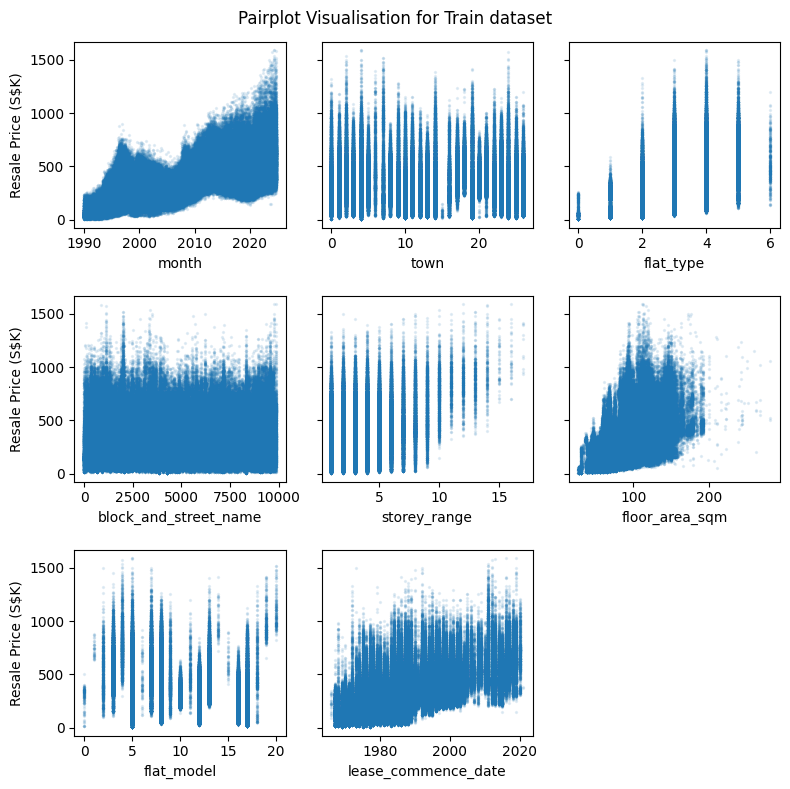

In [4]:
def visualise_pairplot(dframe, title):

    y = dframe['resale_price']
    y_label = 'Resale Price (S$K)'

    feature_to_index_dict = \
        get_feature_to_index_dict(dframe.columns.values.tolist())

    alpha_value = 0.1
    s_value = 2

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey='row')

    # 1st row
    ax[0,0].scatter(x=dframe.iloc[:, \
                    feature_to_index_dict['month']], y=y,
                    alpha=alpha_value, s=s_value)
    ax[0,0].set_xlabel('month')
    ax[0,0].set_ylabel(y_label)

    ax[0,1].scatter(x=dframe.iloc[:, \
                    feature_to_index_dict['town']], y=y,
                    alpha=alpha_value, s=s_value)
    ax[0,1].set_xlabel('town')

    ax[0,2].scatter(x=dframe.iloc[:, \
                    feature_to_index_dict['flat_type']], y=y,
                    alpha=alpha_value, s=s_value)
    ax[0,2].set_xlabel('flat_type')


    # 2nd row
    ax[1,0].scatter(x=dframe.iloc[:, \
                    feature_to_index_dict['block_and_street_name']], y=y,
                    alpha=alpha_value, s=s_value)
    ax[1,0].set_xlabel('block_and_street_name')
    ax[1,0].set_ylabel(y_label)

    ax[1,1].scatter(x=dframe.iloc[:, \
                    feature_to_index_dict['storey_range']], y=y,
                    alpha=alpha_value, s=s_value)
    ax[1,1].set_xlabel('storey_range')

    ax[1,2].scatter(x=dframe.iloc[:, \
                    feature_to_index_dict['floor_area_sqm']], y=y,
                    alpha=alpha_value, s=s_value)
    ax[1,2].set_xlabel('floor_area_sqm')

    # 3rd row
    ax[2,0].scatter(x=dframe.iloc[:, \
                    feature_to_index_dict['flat_model']], y=y,
                    alpha=alpha_value, s=s_value)
    ax[2,0].set_xlabel('flat_model')
    ax[2,0].set_ylabel(y_label)

    ax[2,1].scatter(x=dframe.iloc[:, \
                    feature_to_index_dict['lease_commence_date']], y=y,
                    alpha=alpha_value, s=s_value)
    ax[2,1].set_xlabel('lease_commence_date')

    # Hide the remaining empty plot
    fig.delaxes(ax[2][2])

    plt.suptitle(title)
    plt.tight_layout(h_pad=1.8)
    plt.show()

visualise_pairplot(df_train, 'Pairplot Visualisation for Train dataset')

From the above pairplots, we can faintly discern a loose, somewhat linear relationship between resale_price (our target variable) and the following features:

1. month
2. storey_range
3. floor_area_sqm
4. lease_commence_date

*(You may also notice that as the flat_type goes from 0 to 4, the resale_price increases accordingly. This is because these encoded numbers correspond to the range of '1 ROOM' to '5 ROOM' flats - as the number of rooms of the flat increases, the resale price increases accordingly.)*

### HEATMAP VISUALISATION
We will now proceed to do a heatmap to see if it can help us uncover some useful correlations in the data:

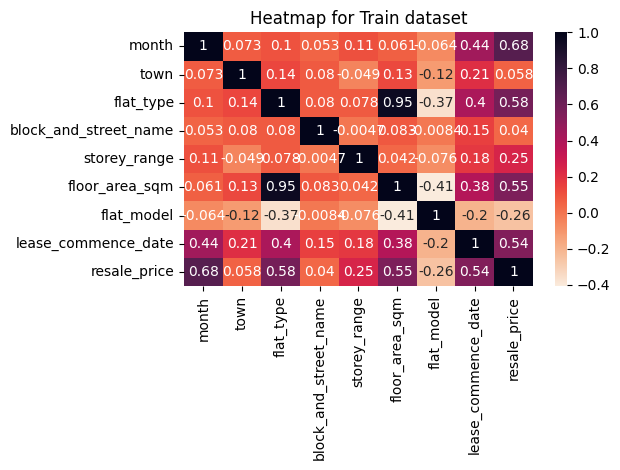

In [5]:
sns.heatmap(df_train.corr(), cmap = 'rocket_r', annot = True)
plt.title('Heatmap for Train dataset')
plt.tight_layout()
plt.show()

We can observe from the heatmap that the features with a higher correlation to resale_price would be:

1. month
2. flat_type
3. floor_area_sqm
4. lease_commence_date
5. storey_range

We can infer from the heatmap and the prior pairplot visualisations that these 5 features, taken together, will have a noticeable impact on resale_price.

This is in line with the following empirical observations:

1. Resale prices have increased over time (the transaction *month* feature).
2. Resale prices are higher for larger *flat types*.
3. Resale prices are higher for flats with more *floor area*.
4. Resale prices are higher for younger flats (more recent *lease commence date*).
5. Resale prices are higher for higher floors of the same block (*storey range*).

[*The remaining 3 features (town, block_and_street_name, flat_model) may seem to have relatively insignificant impact on the resale price, judging from the above visualisations. However, the town does have an impact on the resale prices - a 4 room flat in the central district will typically be more costly than one in the other towns.*

*But the district codes of the flats are not immediately available in the dataset. However, with some work, it would be possible to get the postal codes of the flats by using the block and street names in an API call (ref: <a href="https://www.onemap.gov.sg/apidocs/search" target="_blank">OneMap API</a>). With the postal codes, it would then be possible to figure out the district codes (ref: <a href="https://www.ura.gov.sg/Corporate/-/media/Corporate/Property/PMI-Online/List_Of_Postal_Districts.pdf" target="_blank">URA List of Postal Districts</a>) . If the district code is a feature in the dataset, it may well be an important correlation to the resale price. But this will warrant further exploration that is outside the immediate scope of this notebook.*]

### FEATURE SELECTION AND DATA STANDARDISATION
Before we begin our model creation, for better results, we will first do some **feature selection** in the data.

Using the full dataset, we will first filter to the records that match our selected flat type (3 ROOM). (This allows us to do a 70/30 Train/Test split later on that can accurately capture 70% of all 3 ROOM flat records for use in a new Train dataset, and the remaining 30% of all 3 ROOM flat records for use in a new Test dataset.)

Then, we drop the 3 insignificant features (town, block_and_street_name, flat_model). As the records at this point would all belong to 3 ROOM flats, we can drop the flat_type feature as well to reduce model complexity.

We now do the 70/30 Train/Test split using scikit-learn's built-in 'train_test_split' function. *Note that this function will automatically shuffle the records by default.*

Then we do some **data standardisation** using scikit-learn's 'StandardScaler'. This will help produce better results in the models as it "evens out" the range of values between the various features.

In [6]:
# 'sft' is short for 'selected flat type'
df_sft = df_full.copy()
df_sft = df_sft[(df_sft['flat_type'] == \
    flat_type_encoder.transform([selected_flat_type])[0])]


col_names_to_drop = ['town',
                    'flat_type',
                    'block_and_street_name',
                    'flat_model']

df_sft = df_sft.drop(col_names_to_drop, axis=1)
df_sft.reset_index(drop=True, inplace=True)

df_sft_col_names = df_sft.columns.values.tolist()
print('Column names:', df_sft_col_names)


# All remaining features except the last column will be used for
# training the models
X = df_sft.iloc[:, 0:-1].values

# The last column, resale_price, is our target variable
y = df_sft.iloc[:, -1].values


# Do a 70/30 Train/Test dataset split using scikit-learn.
# '_unstd' suffix to indicate that it is non-standardised data.
X_train_unstd, X_test_unstd, y_train, y_test = train_test_split(X, y,
                                    train_size=0.7,
                                    random_state=random_seed,
                                    shuffle=True)

print('\nSelected flat type dataset shape:', X.shape)
print('\nTrain dataset shape:', X_train_unstd.shape)
print('\nTest dataset shape:', X_test_unstd.shape)


# STANDARDISE THE TRAINING DATA FOR BETTER RESULTS
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train_unstd)
X_test = X_scaler.transform(X_test_unstd)

Column names: ['month', 'storey_range', 'floor_area_sqm', 'lease_commence_date', 'resale_price']

Selected flat type dataset shape: (298943, 4)

Train dataset shape: (209260, 4)

Test dataset shape: (89683, 4)


### ESTABLISHING A BASELINE FOR MODEL PERFORMANCE
At this juncture, it would be useful to establish a reasonable baseline by which we could gauge how effective our model is at predicting the resale price.

Here, I would use the mean resale price for the transaction month, based on the data in the *Train* dataset (keeping with the concept of a Train/Test dataset split). The model can be deemed to work well if its predicted resale prices for the Test dataset are closer to the actual resale prices, compared to the mean resale prices for the respective transaction months.

We use Mean Absolute Error (MAE) for this. We can call this the **Baseline MAE** for the Test dataset. If a model is able to produce an MAE that is lower than this on the Test dataset, we can consider the model to be acceptable.

In [7]:
def generate_df_stat(X_month, y):

    df_ref = pd.DataFrame({'month': X_month,
                            'resale_price': y})


    # This produces a range from 1990.0 to 2024.75 (i.e. the months in their
    # encoded forms), which matches 1990-01 to 2024-10 accordingly
    month_range = np.arange(X_month.min(), (X_month.max() + 1/12), 1/12)
    month_range = np.round(month_range, 2)


    month_value = [mth for mth in month_range]
    mean_value = [np.mean(df_ref['resale_price'][df_ref['month']==mth]) for mth in month_range]
    median_value = [np.median(df_ref['resale_price'][df_ref['month']==mth]) for mth in month_range]
    std_dev_value = [np.std(df_ref['resale_price'][df_ref['month']==mth]) for mth in month_range]

    df_result = pd.DataFrame({'month': month_value, \
                                'mean_resale_price': mean_value, \
                                'median_resale_price': median_value, \
                                'std_dev': std_dev_value})


    return df_result


month_col = 0

df_train_stat = generate_df_stat(X_train_unstd[:, month_col], y_train)

print(f'Mean Resale Prices for {selected_flat_type} Flats\n\n', df_train_stat.head())


# Get the encoded month values in the X_test dataset
X_test_unstd_month = X_test_unstd[:, month_col]

# Calculate the mean resale prices matching those months
y_test_mean = [df_train_stat['mean_resale_price'][df_train_stat['month']==mth] for mth in X_test_unstd_month]

# Calculate the Baseline MAE
y_test_mean_mae = mean_absolute_error(y_true=y_test, y_pred=y_test_mean)

print(f'\nBaseline MAE: {y_test_mean_mae:.3f}')

Mean Resale Prices for 3 ROOM Flats

      month  mean_resale_price  median_resale_price    std_dev
0  1990.00          41.763776                42.50  12.417707
1  1990.08          43.643342                45.00  11.519472
2  1990.17          43.334241                44.00  12.330469
3  1990.25          42.283824                44.90  11.332682
4  1990.33          42.161200                42.95  11.947735

Baseline MAE: 27.158


### OBSERVATIONS ON ESTABLISHING A BASELINE FOR MODEL PERFORMANCE
Our **Baseline MAE** for the Test dataset is $27,158.

Our models should produce a lower MAE score than this in order for it to be acceptable.

### SUPPORT VECTOR REGRESSION (SVR)
This is the first machine learning model that we will explore.<br><br>
As SVR does not handle large datasets well, we will include it here mainly for demonstration purposes.<br><br>
We filter to the first 7,000 records in the (already shuffled) Train dataset, and 3,000 records in the (already shuffled) Test dataset in order to keep the same 70/30 ratio.<br><br>
We run the SVR models with 3 different kernel settings here for comparison - the Radial Basis Function (RBF) kernel, the Linear kernel as well as the Polynomial kernel. The '_default' suffix in the model name will indicate the model using default hyperparameters; the '_custom' suffix will indicate the model using arbitrary hyperparameters (that could be further adjusted for potentially better results).

In [ ]:
# START THE MODEL TRAINING FOR SUPPORT VECTOR REGRESSION =====================

sample_count = 10_000
train_sample_count = int(sample_count * 0.7)
test_sample_count = int(sample_count * 0.3)

actual_count = X.shape[0]

X_train_svr = X_train.copy()
y_train_svr = y_train.copy()

X_test_svr = X_test.copy()
y_test_svr = y_test.copy()


# If the actual number of records is higher than the sample_count,
# we will take the 1st 7,000 (or 70% of the sample_count) of the records
# from the X_train dataset to form our SVR-specific Train dataset, and the 1st
# 3,000 (or 30% of the sample_count) of the records from the X_test
# dataset to form our SVR-specific Test dataset.
if actual_count > sample_count:

    X_train_svr = X_train_svr[0:train_sample_count, :]

    y_train_svr = y_train_svr[0:train_sample_count]

    X_test_svr = X_test_svr[0:test_sample_count, :]

    y_test_svr = y_test_svr[0:test_sample_count]


print('X_train_svr dataset shape:', X_train_svr.shape)
print('X_test_svr dataset shape:', X_test_svr.shape)


print(f'\nStarting SVR model training for {selected_flat_type} flats...')

svr_rbf_default = SVR(kernel="rbf")
svr_rbf_default.fit(X_train_svr, y_train_svr)

svr_rbf_custom = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_rbf_custom.fit(X_train_svr, y_train_svr)

print('SVR (RBF) models trained...')


svr_lin_default = SVR(kernel="linear")
svr_lin_default.fit(X_train_svr, y_train_svr)

svr_lin_custom = SVR(kernel="linear", C=100, gamma="auto")
svr_lin_custom.fit(X_train_svr, y_train_svr)

print('SVR (Linear) models trained...')


svr_poly_default = SVR(kernel="poly")
svr_poly_default.fit(X_train_svr, y_train_svr)

svr_poly_custom = \
    SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
svr_poly_custom.fit(X_train_svr, y_train_svr)

print('SVR (Polynomial) models trained...')


print('Executing predictions now...')

# RBF default results
y_train_pred_rbf_default = svr_rbf_default.predict(X_train_svr)
y_test_pred_rbf_default = svr_rbf_default.predict(X_test_svr)
print(f'\nSVR (RBF-default) | {selected_flat_type} | Train Dataset MAE: {mean_absolute_error(y_true=y_train_svr, y_pred=y_train_pred_rbf_default):.3f}')
print(f'SVR (RBF-default) | {selected_flat_type} |  Train Dataset R-squared: {r2_score(y_true=y_train_svr, y_pred=y_train_pred_rbf_default):.2%}')
print(f'SVR (RBF-default) | {selected_flat_type} | Test Dataset MAE: {mean_absolute_error(y_true=y_test_svr, y_pred=y_test_pred_rbf_default):.3f}')
print(f'SVR (RBF-default) | {selected_flat_type} |  Test Dataset R-squared: {r2_score(y_true=y_test_svr, y_pred=y_test_pred_rbf_default):.2%}')

# RBF custom results
y_train_pred_rbf_custom = svr_rbf_custom.predict(X_train_svr)
y_test_pred_rbf_custom = svr_rbf_custom.predict(X_test_svr)
print(f'\nSVR (RBF-custom) | {selected_flat_type} | Train Dataset MAE: {mean_absolute_error(y_true=y_train_svr, y_pred=y_train_pred_rbf_custom):.3f}')
print(f'SVR (RBF-custom) | {selected_flat_type} |  Train Dataset R-squared: {r2_score(y_true=y_train_svr, y_pred=y_train_pred_rbf_custom):.2%}')
print(f'SVR (RBF-custom) | {selected_flat_type} | Test Dataset MAE: {mean_absolute_error(y_true=y_test_svr, y_pred=y_test_pred_rbf_custom):.3f}')
print(f'SVR (RBF-custom) | {selected_flat_type} |  Test Dataset R-squared: {r2_score(y_true=y_test_svr, y_pred=y_test_pred_rbf_custom):.2%}')

# Linear default results
y_train_pred_lin_default = svr_lin_default.predict(X_train_svr)
y_test_pred_lin_default = svr_lin_default.predict(X_test_svr)
print(f'\nSVR (Linear-default) | {selected_flat_type} | Train Dataset MAE: {mean_absolute_error(y_true=y_train_svr, y_pred=y_train_pred_lin_default):.3f}')
print(f'SVR (Linear-default) | {selected_flat_type} | Train Dataset R-squared: {r2_score(y_true=y_train_svr, y_pred=y_train_pred_lin_default):.2%}')
print(f'SVR (Linear-default) | {selected_flat_type} | Test Dataset MAE: {mean_absolute_error(y_true=y_test_svr, y_pred=y_test_pred_lin_default):.3f}')
print(f'SVR (Linear-default) | {selected_flat_type} | Test Dataset R-squared: {r2_score(y_true=y_test_svr, y_pred=y_test_pred_lin_default):.2%}')

# Linear custom results
y_train_pred_lin_custom = svr_lin_custom.predict(X_train_svr)
y_test_pred_lin_custom = svr_lin_custom.predict(X_test_svr)
print(f'\nSVR (Linear-custom) | {selected_flat_type} | Train Dataset MAE: {mean_absolute_error(y_true=y_train_svr, y_pred=y_train_pred_lin_custom):.3f}')
print(f'SVR (Linear-custom) | {selected_flat_type} | Train Dataset R-squared: {r2_score(y_true=y_train_svr, y_pred=y_train_pred_lin_custom):.2%}')
print(f'SVR (Linear-custom) | {selected_flat_type} | Test Dataset MAE: {mean_absolute_error(y_true=y_test_svr, y_pred=y_test_pred_lin_custom):.3f}')
print(f'SVR (Linear-custom) | {selected_flat_type} | Test Dataset R-squared: {r2_score(y_true=y_test_svr, y_pred=y_test_pred_lin_custom):.2%}')

# Polynomial default results
y_train_pred_poly_default = svr_poly_default.predict(X_train_svr)
y_test_pred_poly_default = svr_poly_default.predict(X_test_svr)
print(f'\nSVR (Polynomial-default) | {selected_flat_type} | Train Dataset MAE: {mean_absolute_error(y_true=y_train_svr, y_pred=y_train_pred_poly_default):.3f}')
print(f'SVR (Polynomial-default) | {selected_flat_type} | Train Dataset R-squared: {r2_score(y_true=y_train_svr, y_pred=y_train_pred_poly_default):.2%}')
print(f'SVR (Polynomial-default) | {selected_flat_type} | Test Dataset MAE: {mean_absolute_error(y_true=y_test_svr, y_pred=y_test_pred_poly_default):.3f}')
print(f'SVR (Polynomial-default) | {selected_flat_type} | Test Dataset R-squared: {r2_score(y_true=y_test_svr, y_pred=y_test_pred_poly_default):.2%}')

# Polynomial custom results
y_train_pred_poly_custom = svr_poly_custom.predict(X_train_svr)
y_test_pred_poly_custom = svr_poly_custom.predict(X_test_svr)
print(f'\nSVR (Polynomial-custom) | {selected_flat_type} | Train Dataset MAE: {mean_absolute_error(y_true=y_train_svr, y_pred=y_train_pred_poly_custom):.3f}')
print(f'SVR (Polynomial-custom) | {selected_flat_type} | Train Dataset R-squared: {r2_score(y_true=y_train_svr, y_pred=y_train_pred_poly_custom):.2%}')
print(f'SVR (Polynomial-custom) | {selected_flat_type} | Test Dataset MAE: {mean_absolute_error(y_true=y_test_svr, y_pred=y_test_pred_poly_custom):.3f}')
print(f'SVR (Polynomial-custom) | {selected_flat_type} | Test Dataset R-squared: {r2_score(y_true=y_test_svr, y_pred=y_test_pred_poly_custom):.2%}')


X_train_svr dataset shape: (7000, 4)
X_test_svr dataset shape: (3000, 4)

Starting SVR model training for 3 ROOM flats...
SVR (RBF) models trained...
SVR (Linear) models trained...
SVR (Polynomial) models trained...
Executing predictions now...

SVR (RBF-default) | 3 ROOM | Train Dataset MAE: 42.817
SVR (RBF-default) | 3 ROOM |  Train Dataset R-squared: 68.28%
SVR (RBF-default) | 3 ROOM | Test Dataset MAE: 42.304
SVR (RBF-default) | 3 ROOM |  Test Dataset R-squared: 70.23%

SVR (RBF-custom) | 3 ROOM | Train Dataset MAE: 34.494
SVR (RBF-custom) | 3 ROOM |  Train Dataset R-squared: 81.85%
SVR (RBF-custom) | 3 ROOM | Test Dataset MAE: 34.319
SVR (RBF-custom) | 3 ROOM |  Test Dataset R-squared: 82.21%

SVR (Linear-default) | 3 ROOM | Train Dataset MAE: 37.656
SVR (Linear-default) | 3 ROOM | Train Dataset R-squared: 77.38%
SVR (Linear-default) | 3 ROOM | Test Dataset MAE: 36.810
SVR (Linear-default) | 3 ROOM | Test Dataset R-squared: 78.56%

SVR (Linear-custom) | 3 ROOM | Train Dataset MAE:

### OBSERVATIONS ON SUPPORT VECTOR REGRESSION
Best-performing model:
>SVR (RBF-custom) | 3 ROOM | Train Dataset MAE: 34.494<br>
SVR (RBF-custom) | 3 ROOM |  Train Dataset R-squared: 81.85%<br>
SVR (RBF-custom) | 3 ROOM | Test Dataset MAE: 34.319<br>
SVR (RBF-custom) | 3 ROOM |  Test Dataset R-squared: 82.21%<br>

The RBF kernel with arbitrarily selected hyperparameters seems to perform better here than the other models. It could potentially be adjusted for better performance using different hyperparameters, but ultimately it is not a practical solution for the context of this notebook, due the relatively large size of the dataset. Theoretically the model could work but it would take too long to train and to execute the predictions.

### INTERPRETING THE MODEL RESULTS
**MAE: Mean Absolute Error**<br>
I have chosen to use MAE (as opposed to Mean Squared Error) as it is more intuitive here.

If the MAE is 34.319 on the Test dataset, that means when the model generates resale price predictions, the average of the absolute errors is $34,319.<br>
The lower the MAE, the more accurate the model.

**R-squared: $R^2$ aka Coefficient of Determination**<br>
This value tells us how well the model can predict the resale_price, based on the other features of the dataset (i.e. month, storey_range, floor_area_sqm, and lease_commence_date). The higher the $R^2$, the more accurate the model.

### LINEAR REGRESSION

Now we try the Linear Regression models, first with the standard settings, and then with the Polynomial models of varying degrees.

In [ ]:
# START THE MODEL TRAINING FOR LINEAR REGRESSION ===============================

print(f'\nStarting Linear Regression model training for {selected_flat_type} flats...')


# STANDARD LINEAR REGRESSION
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_train_pred_lin_reg = lin_reg.predict(X_train)
y_test_pred_lin_reg = lin_reg.predict(X_test)
print(f'\nLinear Regression (Standard) | {selected_flat_type} | Train Dataset MAE: {mean_absolute_error(y_true=y_train, y_pred=y_train_pred_lin_reg):.3f}')
print(f'Linear Regression (Standard) | {selected_flat_type} | Train Dataset R-squared: {r2_score(y_true=y_train, y_pred=y_train_pred_lin_reg):.2%}')
print(f'Linear Regression (Standard) | {selected_flat_type} | Test Dataset MAE: {mean_absolute_error(y_true=y_test, y_pred=y_test_pred_lin_reg):.3f}')
print(f'Linear Regression (Standard) | {selected_flat_type} | Test Dataset R-squared: {r2_score(y_true=y_test, y_pred=y_test_pred_lin_reg):.2%}')


# LINEAR REGRESSION USING POLYNOMIAL FEATURES
poly_degree_start = 2
poly_degree_end = 10
poly_range = range(poly_degree_start, poly_degree_end + 1)
for i in poly_range:

    poly = PolynomialFeatures(degree=i)

    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    lin_reg_poly = LinearRegression()
    lin_reg_poly.fit(X_train_poly, y_train)

    y_train_pred_lin_reg_poly = lin_reg_poly.predict(X_train_poly)
    y_test_pred_lin_reg_poly = lin_reg_poly.predict(X_test_poly)
    print(f'\nLinear Regression (Polynomial Degree = {i}) | {selected_flat_type} | Train Dataset MAE: {mean_absolute_error(y_true=y_train, y_pred=y_train_pred_lin_reg_poly):.3f}')
    print(f'Linear Regression (Polynomial Degree = {i}) | {selected_flat_type} | Train Dataset R-squared: {r2_score(y_true=y_train, y_pred=y_train_pred_lin_reg_poly):.2%}')
    print(f'Linear Regression (Polynomial Degree = {i}) | {selected_flat_type} | Test Dataset MAE: {mean_absolute_error(y_true=y_test, y_pred=y_test_pred_lin_reg_poly):.3f}')
    print(f'Linear Regression (Polynomial Degree = {i}) | {selected_flat_type} | Test Dataset R-squared: {r2_score(y_true=y_test, y_pred=y_test_pred_lin_reg_poly):.2%}')



Starting Linear Regression model training for 3 ROOM flats...

Linear Regression (Standard) | 3 ROOM | Train Dataset MAE: 38.072
Linear Regression (Standard) | 3 ROOM | Train Dataset R-squared: 77.97%
Linear Regression (Standard) | 3 ROOM | Test Dataset MAE: 37.917
Linear Regression (Standard) | 3 ROOM | Test Dataset R-squared: 78.24%

Linear Regression (Polynomial Degree = 2) | 3 ROOM | Train Dataset MAE: 36.607
Linear Regression (Polynomial Degree = 2) | 3 ROOM | Train Dataset R-squared: 80.44%
Linear Regression (Polynomial Degree = 2) | 3 ROOM | Test Dataset MAE: 36.525
Linear Regression (Polynomial Degree = 2) | 3 ROOM | Test Dataset R-squared: 80.53%

Linear Regression (Polynomial Degree = 3) | 3 ROOM | Train Dataset MAE: 36.125
Linear Regression (Polynomial Degree = 3) | 3 ROOM | Train Dataset R-squared: 81.14%
Linear Regression (Polynomial Degree = 3) | 3 ROOM | Test Dataset MAE: 36.040
Linear Regression (Polynomial Degree = 3) | 3 ROOM | Test Dataset R-squared: 81.22%

Linear 

### OBSERVATIONS ON LINEAR REGRESSION
Best-performing model:
>Linear Regression (Polynomial Degree = 7) | 3 ROOM | Train Dataset MAE: 24.897<br>
Linear Regression (Polynomial Degree = 7) | 3 ROOM | Train Dataset R-squared: 90.47%<br>
Linear Regression (Polynomial Degree = 7) | 3 ROOM | Test Dataset MAE: 24.992<br>
Linear Regression (Polynomial Degree = 7) | 3 ROOM | Test Dataset R-squared: 90.33%

Linear Regression with Polynomial Degree of 7 seem to work best for our selected flat type of 3 ROOM flats.

Models with a polynomial degree higher than 7 produce progressively worse results.

### DECISION TREE REGRESSION
We will now evaluate the data using **Decision Tree Regression**, with a variety of tree depths.

As decision trees do not require feature-scaling, we will use the "unstandardised" versions of the X_train and X_test datasets here (i.e. X_train_unstd and X_test_unstd respectively).

In [ ]:
tree_depth_start = 1
tree_depth_end = 15
tree_depth_range = range(tree_depth_start, tree_depth_end + 1)

print(f'Starting Decision Tree Regression model training for '
        f'{selected_flat_type} flats...')


for tree_depth in tree_depth_range:

    tree = DecisionTreeRegressor(max_depth=tree_depth)
    tree.fit(X_train_unstd, y_train)

    train_r2_score = r2_score(y_train, tree.predict(X_train_unstd))
    train_mae = mean_absolute_error(y_true=y_train, y_pred=tree.predict(X_train_unstd))
    test_r2_score = r2_score(y_test, tree.predict(X_test_unstd))
    test_mae = mean_absolute_error(y_true=y_test, y_pred=tree.predict(X_test_unstd))

    print(f'\nDecision Tree Regression (Depth = {tree_depth}) | {selected_flat_type} | Train Dataset MAE: {train_mae:.3f}')
    print(f'Decision Tree Regression (Depth = {tree_depth}) | {selected_flat_type} | Train Dataset R-squared : {train_r2_score:.2%}')
    print(f'Decision Tree Regression (Depth = {tree_depth}) | {selected_flat_type} | Test Dataset MAE: {test_mae:.3f}')
    print(f'Decision Tree Regression (Depth = {tree_depth}) | {selected_flat_type} | Test Dataset R-squared : {test_r2_score:.2%}')

Starting Decision Tree Regression model training for 3 ROOM flats...

Decision Tree Regression (Depth = 1) | 3 ROOM | Train Dataset MAE: 46.465
Decision Tree Regression (Depth = 1) | 3 ROOM | Train Dataset R-squared : 65.53%
Decision Tree Regression (Depth = 1) | 3 ROOM | Test Dataset MAE: 46.259
Decision Tree Regression (Depth = 1) | 3 ROOM | Test Dataset R-squared : 66.09%

Decision Tree Regression (Depth = 2) | 3 ROOM | Train Dataset MAE: 35.308
Decision Tree Regression (Depth = 2) | 3 ROOM | Train Dataset R-squared : 78.67%
Decision Tree Regression (Depth = 2) | 3 ROOM | Test Dataset MAE: 35.007
Decision Tree Regression (Depth = 2) | 3 ROOM | Test Dataset R-squared : 79.23%

Decision Tree Regression (Depth = 3) | 3 ROOM | Train Dataset MAE: 30.887
Decision Tree Regression (Depth = 3) | 3 ROOM | Train Dataset R-squared : 82.58%
Decision Tree Regression (Depth = 3) | 3 ROOM | Test Dataset MAE: 30.694
Decision Tree Regression (Depth = 3) | 3 ROOM | Test Dataset R-squared : 83.01%

Dec

### OBSERVATIONS ON DECISION TREE REGRESSION
Best-performing model:
>Decision Tree Regression (Depth = 9) | 3 ROOM | Train Dataset MAE: 21.496<br>
Decision Tree Regression (Depth = 9) | 3 ROOM | Train Dataset R-squared : 91.91%<br>
Decision Tree Regression (Depth = 9) | 3 ROOM | Test Dataset MAE: 21.836<br>
Decision Tree Regression (Depth = 9) | 3 ROOM | Test Dataset R-squared : 91.48%

A depth of 9 works well for our selected flat type of 3 ROOM flats; models with a depth of more than 9 will overfit and will not generalise well.

*Signs that the model is overfitting: MAE for the Test dataset is a fair bit higher than for the Train dataset, and $R^2$ for the Test dataset is a fair bit lower than for the Train dataset. See the model with a tree depth of 15 for an obvious example.*


### DEEP LEARNING FOR REGRESSION (USING KERAS/TENSORFLOW)
The following plot is from '**Deep Learning with Python (2nd edition)**' by Francois Chollet (the creator of Keras).<br><br>
<style>
img {
  border: 5px solid #555;
}
</style>
<img src="https://raw.githubusercontent.com/prog4321/hdb_resale/refs/heads/main/images/chollet_fig_5_1.svg">

It shows the ideal training and validation curves when training a good deep learning model. The idea is to first get the model to be able to overfit, and then to stop the training at the appropriate epoch (i.e. training time) in order to have the model retain optimal weights at the point of the robust fit. Such a model will be able to generalise better to a variety of datasets and offer more reliable performance.

Below, I have developed a framework with which to try out different hyperparameters with a view to finding a plot that comes close to what is shown in Fig 5.1.

In the interest of brevity, where the plots are concerned, I have omitted some hyperparameters that I know do not work well.



In [1]:
# Function call for reproducibility of NN training results
def reset_seeds(seed_num):
    keras.utils.set_random_seed(random_seed)
    np.random.seed(seed_num)
    python_random.seed(seed_num)
    tf.random.set_seed(seed_num)
    tf.config.experimental.enable_op_determinism()


# Function with which to define an array of varying model architectures and
# varying hyperparameters that is then passed into the 'train_nn' function
# for training
def get_model_array(hidden_layer_count,
                    seed_list,
                    node_list,
                    learning_rate_list,
                    batch_size_list):

    model_layer_array = []
    model_optimizer_array = []
    batch_size_array = []
    hyperparameter_array = []


    for seed in seed_list:

        for node in node_list:

            for learning_rate in learning_rate_list:

                for batch_size in batch_size_list:

                    # We cater for a maximum of 3 layers.
                    # As we are using the model for regression, the
                    # last Dense layer should only contain 1 node.
                    if hidden_layer_count == 1:

                        model_layer_array.append([
                            layers.Dense(node, activation='relu'),
                            layers.Dense(1)
                            ])

                    elif hidden_layer_count == 2:

                        model_layer_array.append([
                            layers.Dense(node, activation='relu'),
                            layers.Dense(node, activation='relu'),
                            layers.Dense(1)
                            ])

                    else:

                        model_layer_array.append([
                            layers.Dense(node, activation='relu'),
                            layers.Dense(node, activation='relu'),
                            layers.Dense(node, activation='relu'),
                            layers.Dense(1)
                            ])

                    model_optimizer_array.append(keras.optimizers.RMSprop(learning_rate))

                    batch_size_array.append(batch_size)

                    # 'S' for seed
                    # 'HL' for hidden_layer_count
                    # 'N' for number of nodes per layer
                    # 'LR' for learning_rate
                    # 'BS' for batch_size
                    hyperparameter_array.append('S' + str(seed) + ';' + \
                                                'HL' + str(hidden_layer_count) + ';' + \
                                                'N' + str(node) + ';' + \
                                                'LR' + str(learning_rate) + ';' + \
                                                'BS' + str(batch_size)
                                                )
                    # This hyperparameter array gives us a quick insight
                    # into the hyperparameter settings


    return model_layer_array, \
            model_optimizer_array, \
            batch_size_array, \
            hyperparameter_array


# Train the models and output the training and validation losses
# as a list
def train_nn(model_layer_array,
            model_optimizer_array,
            batch_size_array,
            hyperparameter_array,
            epoch_count,
            seed_list):

    # CONSTANT VALUES
    loss_function = 'mae'
    selected_metrics = [R2Score()]
    val_split_value = 0.3


    loss_values_list = []
    val_loss_values_list = []


    print(f'\nStarting Keras Deep Learning model training for '
        f'{selected_flat_type} flats...')

    model_count = int(len(batch_size_array) / len(seed_list))


    model_index = 0
    for seed in seed_list:

        print(f'\nSetting random seed to {seed}')
        reset_seeds(seed)

        for i in range(0, model_count):

            model_layer = model_layer_array[model_index]
            model_optimizer = model_optimizer_array[model_index]
            batch_size = batch_size_array[model_index]
            hyperparameter = hyperparameter_array[model_index]

            print(f'\nTraining Keras Deep Learning ('
                f'Hyperparameters: {hyperparameter})')


            model = keras.Sequential(model_layer)

            model.compile(optimizer=model_optimizer,
                loss=loss_function,
                metrics=selected_metrics)

            hist = model.fit(X_train,
                            y_train,
                            epochs=epoch_count,
                            batch_size=batch_size,
                            validation_split=val_split_value,
                            verbose=True)

            model_history = hist.history

            loss_values_list.append(model_history['loss'])
            val_loss_values_list.append(model_history['val_loss'])

            model_index += 1


    return loss_values_list, \
            val_loss_values_list


# Takes in the training and validation losses from the 'train_nn'
# and plots the results
def display_nn_training_results(loss_values_list,
                                val_loss_values_list,
                                hyperparameter_array,
                                epoch_count,
                                seed_list,
                                vis_epoch_start=1):

    seed_count = len(seed_list)
    model_count = int(len(hyperparameter_array) / seed_count)

    match seed_count:
        case 1:
            col_size = 3
        case 2:
            col_size = 6
        case 3:
            col_size = 9
        case _:
            col_size = 12

    row_size = model_count * 3


    # Generate a visualisation plot
    fig, ax = plt.subplots(nrows=model_count,
                           ncols=seed_count,
                           figsize=(col_size, row_size),
                           sharey='row')

    subplot_title_fontsize = 8

    index = 0
    for j in range(0, seed_count):

        for i in range(0, model_count):

            vis_epochs_range = \
                range(vis_epoch_start, epoch_count + 1)

            loss_values = loss_values_list[index][vis_epoch_start-1:]

            val_loss_values = val_loss_values_list[index][vis_epoch_start-1:]

            hyperparameter = hyperparameter_array[index]


            if (seed_count == 1) and (model_count == 1):

                ax.set_title(hyperparameter, fontsize=subplot_title_fontsize)
                ax.set_xlabel('Epochs')

                ax.plot(vis_epochs_range, loss_values, 'b',
                                label='Training Loss')
                ax.plot(vis_epochs_range, val_loss_values, 'r',
                                label='Validation Loss')
                ax.set_ylabel('Loss (MAE)')

                ax.grid(True)
                ax.legend()

            elif (seed_count == 1) and (model_count > 1):

                ax[i].set_title(hyperparameter, fontsize=subplot_title_fontsize)
                ax[i].set_xlabel('Epochs')

                ax[i].plot(vis_epochs_range, loss_values, 'b',
                                label='Training Loss')
                ax[i].plot(vis_epochs_range, val_loss_values, 'r',
                                label='Validation Loss')
                ax[i].set_ylabel('Loss (MAE)')

                ax[i].grid(True)
                ax[i].legend()

            elif (seed_count > 1) and (model_count == 1):

                ax[j].set_title(hyperparameter, fontsize=subplot_title_fontsize)
                ax[j].set_xlabel('Epochs')

                ax[j].plot(vis_epochs_range, loss_values, 'b',
                            label='Training Loss')
                ax[j].plot(vis_epochs_range, val_loss_values, 'r',
                            label='Validation Loss')
                ax[j].set_ylabel('Loss (MAE)')

                ax[j].grid(True)
                ax[j].legend()

            else:

                ax[i,j].set_title(hyperparameter, fontsize=subplot_title_fontsize)
                ax[i,j].set_xlabel('Epochs')

                ax[i,j].plot(vis_epochs_range, loss_values, 'b',
                            label='Training Loss')
                ax[i,j].plot(vis_epochs_range, val_loss_values, 'r',
                            label='Validation Loss')

                if j == 0:
                    ax[i,j].set_ylabel('Loss (MAE)')

                ax[i,j].legend()
                ax[i,j].grid(True)

            index += 1


    plt.suptitle('Keras Deep Learning Training')
    plt.tight_layout(rect=[0, 0, 0.98, 0.98])
    plt.show()

We'll start with models that have 1 hidden layer, with a variety of nodes, and 2 different batch sizes.

In [ ]:
epoch_count_gp1 = 50
hidden_layer_count_gp1 = 1
node_list_gp1 = [128, 256, 512, 1024]
learning_rate_list_gp1 = [0.001] # default learning rate for RMSprop optimizer
batch_size_list_gp1 = [512, 1024]


model_layer_array_gp1, \
    model_optimizer_array_gp1, \
    batch_size_array_gp1, \
    hyperparameter_array_gp1 = \
    get_model_array(hidden_layer_count=hidden_layer_count_gp1,
                    seed_list=random_seed_list,
                    node_list=node_list_gp1,
                    learning_rate_list=learning_rate_list_gp1,
                    batch_size_list=batch_size_list_gp1)


loss_values_list_gp1, val_loss_values_list_gp1 = \
    train_nn(model_layer_array=model_layer_array_gp1,
            model_optimizer_array=model_optimizer_array_gp1,
            batch_size_array=batch_size_array_gp1,
            hyperparameter_array=hyperparameter_array_gp1,
            epoch_count=epoch_count_gp1,
            seed_list=random_seed_list)


Starting Keras Deep Learning model training for 3 ROOM flats...

Setting random seed to 123

Training Keras Deep Learning (Hyperparameters: S123;HL1;N128;LR0.001;BS512)
Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 201.1090 - r2_score: -3.2942 - val_loss: 187.0163 - val_r2_score: -2.8726
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 177.9546 - r2_score: -2.5279 - val_loss: 148.3753 - val_r2_score: -1.6451
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 135.7809 - r2_score: -1.2416 - val_loss: 95.9008 - val_r2_score: -0.2116
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 82.0386 - r2_score: 0.0774 - val_loss: 49.6995 - val_r2_score: 0.6104
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 45.8481 - r2_score: 0.6729 - val_loss: 40.7153 - val_r2_score: 0.7387
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39.8519 - r2_score: 0.7561 - val_loss: 38.5900 - val_r2_score: 0.7679
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━

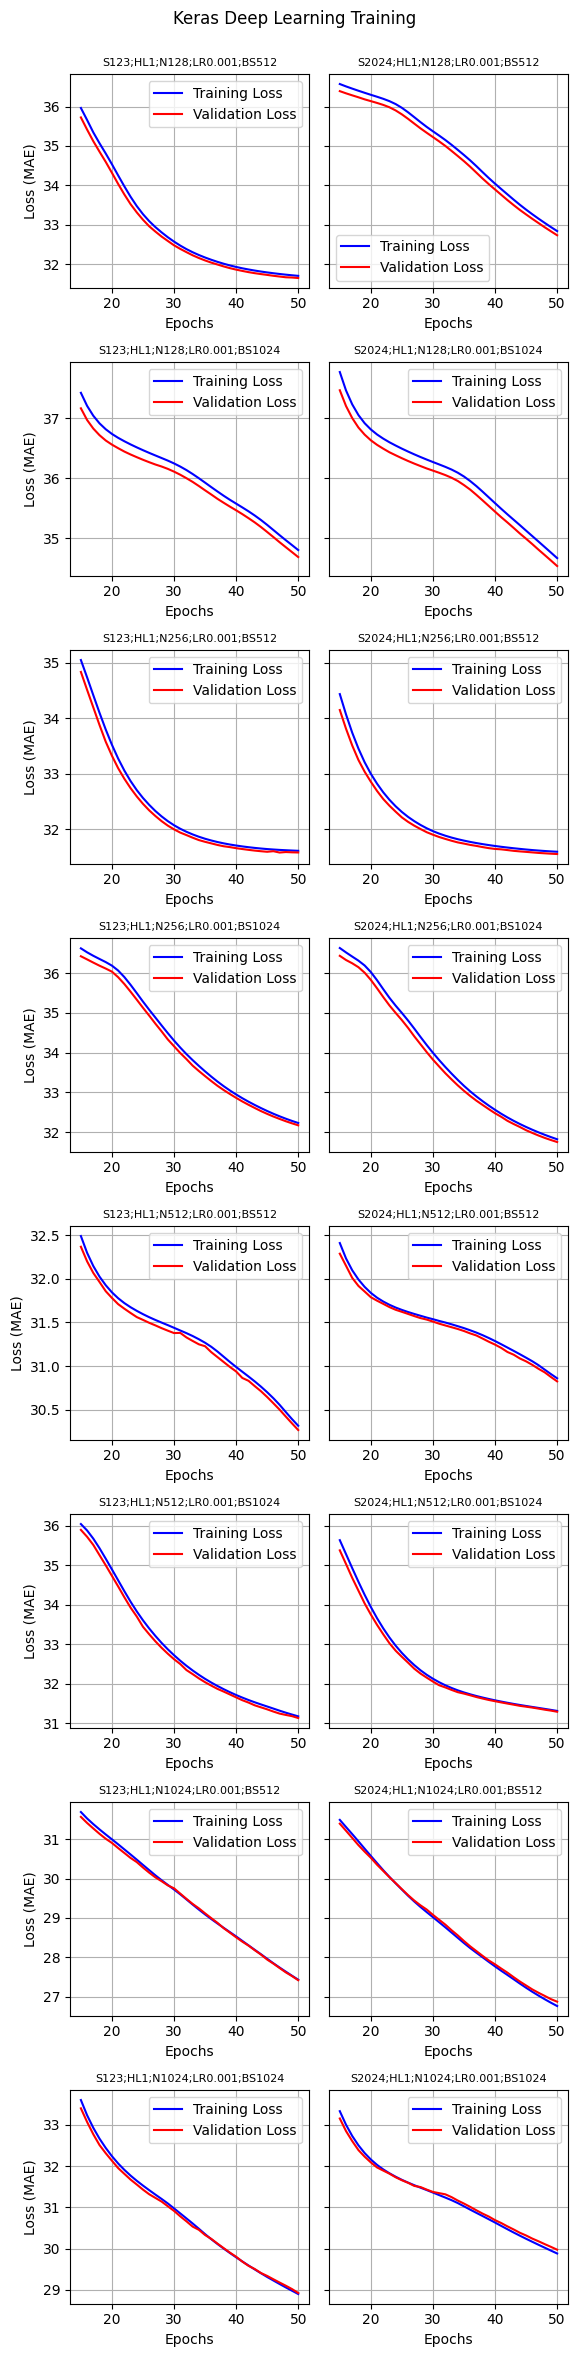

In [ ]:
display_nn_training_results(loss_values_list=loss_values_list_gp1, \
                            val_loss_values_list=val_loss_values_list_gp1, \
                            hyperparameter_array=hyperparameter_array_gp1, \
                            epoch_count=epoch_count_gp1,  \
                            seed_list=random_seed_list, \
                            vis_epoch_start=15)

We can see from the above plots that the models are underfitting.

We can tackle this by increasing the model complexity - either by increasing the number of nodes of the existing hidden layer, or by adding another hidden layer.

We'll try the latter option, using models with 2 hidden layers, with a variety of nodes.

In [ ]:
epoch_count_gp2 = 50
hidden_layer_count_gp2 = 2
node_list_gp2 = [32, 64, 128]
learning_rate_list_gp2 = [0.001]
batch_size_list_gp2 = [512, 1024]


model_layer_array_gp2, \
    model_optimizer_array_gp2, \
    batch_size_array_gp2, \
    hyperparameter_array_gp2 = \
    get_model_array(hidden_layer_count=hidden_layer_count_gp2,
                    seed_list=random_seed_list,
                    node_list=node_list_gp2,
                    learning_rate_list=learning_rate_list_gp2,
                    batch_size_list=batch_size_list_gp2)


loss_values_list_gp2, val_loss_values_list_gp2 = \
    train_nn(model_layer_array=model_layer_array_gp2,
            model_optimizer_array=model_optimizer_array_gp2,
            batch_size_array=batch_size_array_gp2,
            hyperparameter_array=hyperparameter_array_gp2,
            epoch_count=epoch_count_gp2,
            seed_list=random_seed_list)


Starting Keras Deep Learning model training for 3 ROOM flats...

Setting random seed to 123

Training Keras Deep Learning (Hyperparameters: S123;HL2;N32;LR0.001;BS512)
Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 196.5026 - r2_score: -3.1312 - val_loss: 142.0525 - val_r2_score: -1.4202
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 109.6224 - r2_score: -0.5708 - val_loss: 44.6245 - val_r2_score: 0.6906
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 42.2895 - r2_score: 0.7305 - val_loss: 39.0148 - val_r2_score: 0.7695
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 38.3935 - r2_score: 0.7784 - val_loss: 37.6044 - val_r2_score: 0.7831
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37.3256 - r2_score: 0.7878 - val_loss: 36.9900 - val_r2_score: 0.7883
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36.7887 - r2_score: 0.7921 - val_loss: 36.5182 - val_r2_score: 0.7927
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2m

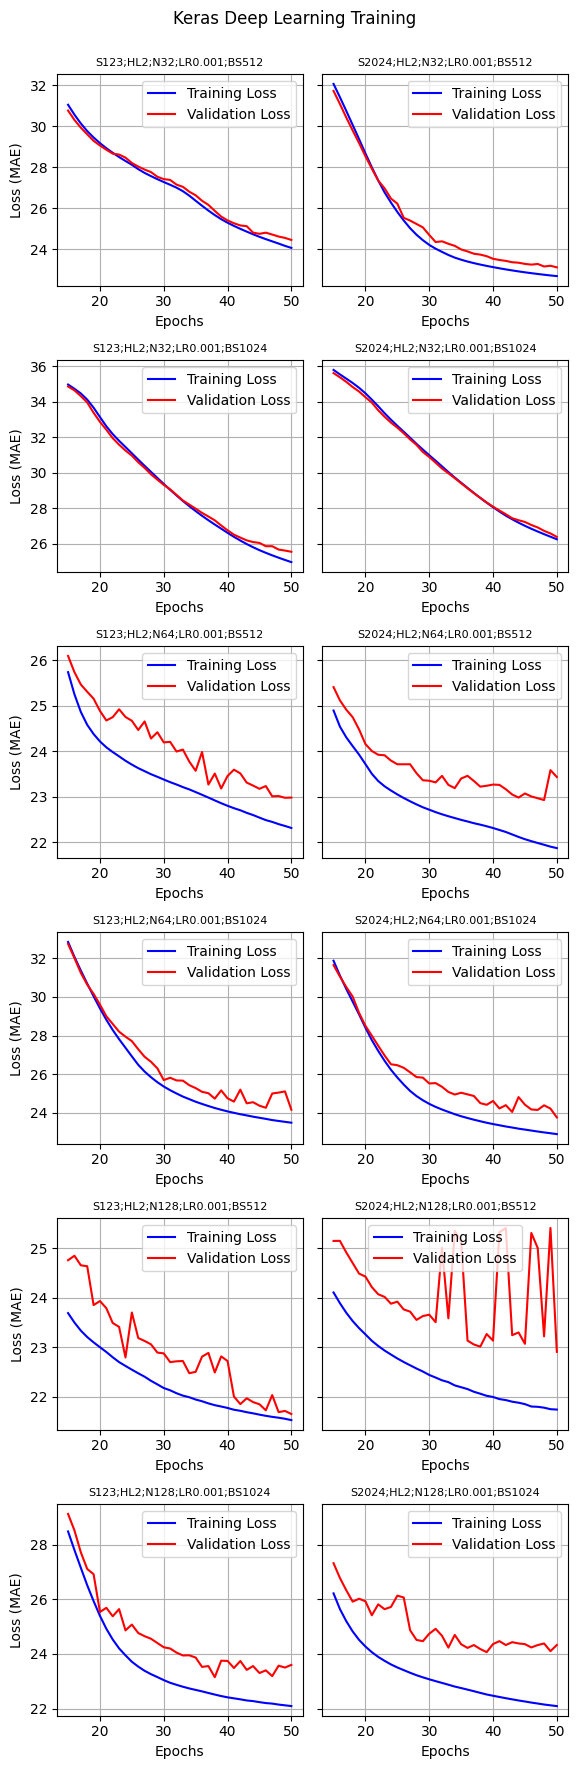

In [ ]:
display_nn_training_results(loss_values_list=loss_values_list_gp2, \
                            val_loss_values_list=val_loss_values_list_gp2, \
                            hyperparameter_array=hyperparameter_array_gp2, \
                            epoch_count=epoch_count_gp2,  \
                            seed_list=random_seed_list, \
                            vis_epoch_start=15)

The most promising of the above plots would seem to be with 2 hidden layers of 64 nodes each, with a batch size of 1,024:<br><br>


<img src="https://raw.githubusercontent.com/prog4321/hdb_resale/refs/heads/main/images/nn_plots_gp2_shortlist.svg">

We can observe that with other models that have 2 hidden layers of 128 nodes each, the models start to overfit badly.

We can start to fine-tune, with models that have nodes from 64 to 88 per layer, with 2 different batch sizes, and now with different learning rates as well. (A lower learning rate can help smoothen erratic validation curves when the model starts to overfit.)

In [ ]:
epoch_count_gp3 = 50
hidden_layer_count_gp3 = 2
node_list_gp3 = [64, 72, 80, 88]
learning_rate_list_gp3 = [0.001, 0.00095, 0.0009, 0.00085]
batch_size_list_gp3 = [1024, 2048]


model_layer_array_gp3, \
    model_optimizer_array_gp3, \
    batch_size_array_gp3, \
    hyperparameter_array_gp3 = \
    get_model_array(hidden_layer_count=hidden_layer_count_gp3,
                    seed_list=random_seed_list,
                    node_list=node_list_gp3,
                    learning_rate_list=learning_rate_list_gp3,
                    batch_size_list=batch_size_list_gp3)


loss_values_list_gp3, val_loss_values_list_gp3 = \
    train_nn(model_layer_array=model_layer_array_gp3,
            model_optimizer_array=model_optimizer_array_gp3,
            batch_size_array=batch_size_array_gp3,
            hyperparameter_array=hyperparameter_array_gp3,
            epoch_count=epoch_count_gp3,
            seed_list=random_seed_list)

Streaming output truncated to the last 5000 lines.
Training Keras Deep Learning (Hyperparameters: S123;HL2;N72;LR0.00085;BS2048)
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 202.4814 - r2_score: -1.2092 - val_loss: 194.5783 - val_r2_score: -3.1381
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 188.9427 - r2_score: -2.8951 - val_loss: 170.2880 - val_r2_score: -2.3588
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 161.4702 - r2_score: -2.0353 - val_loss: 133.6075 - val_r2_score: -1.2171
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 122.3049 - r2_score: -0.8799 - val_loss: 88.5558 - val_r2_score: -0.0770
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79.2471 - r2_score: 0.1175 - val_loss: 57.5676 - val_r2_score: 0.4908
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.2624 - r2_score: 0.5669 - val_loss: 45.3340 - val_r2_score: 0.6804
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.9815 - r2_score: 0.7081 - 

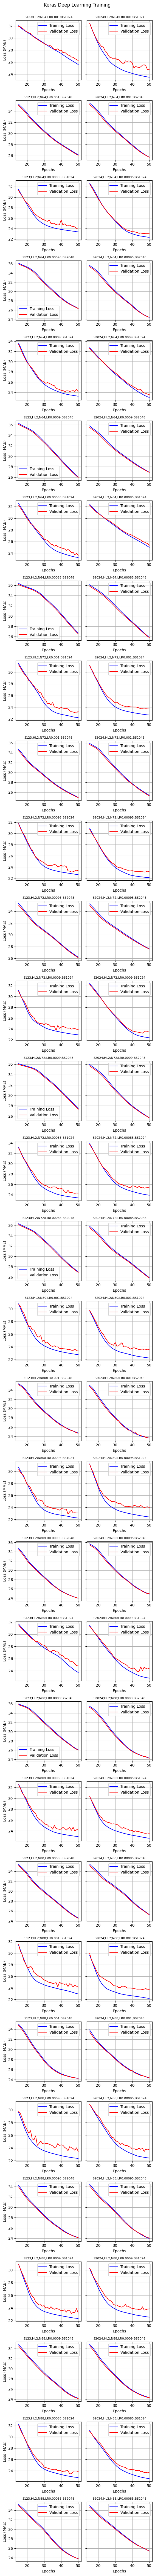

In [ ]:
display_nn_training_results(loss_values_list=loss_values_list_gp3, \
                            val_loss_values_list=val_loss_values_list_gp3, \
                            hyperparameter_array=hyperparameter_array_gp3, \
                            epoch_count=epoch_count_gp3,  \
                            seed_list=random_seed_list, \
                            vis_epoch_start=15)

We can observe the plots are getting closer to the one in Chollet's Fig. 5.1.

We will choose the following one, as at the point of robust fit (around 25 epochs), the MAE is comparatively lower than with the other plots:<br><br>

<img src="https://raw.githubusercontent.com/prog4321/hdb_resale/refs/heads/main/images/nn_plots_gp3_shortlist.svg">

We will use these hyperparameters of the model and train our final deep learning model:

No. of layers: 2<br>
No. of nodes per layer: 72<br>
Learning rate: 0.00095<br>
Batch size: 1,024<br>
No. of training epochs: 25

In [13]:
# Hyperparameters
nodes = 72
learning_rate = 0.00095
batch_size = 1024
epoch_num = 25


model_optimizer = keras.optimizers.RMSprop(learning_rate)
loss_function = 'mae'
selected_metrics = [R2Score()]


reset_seeds(random_seed)

dl_model = keras.Sequential([
                layers.Dense(nodes, activation='relu'),
                layers.Dense(nodes, activation='relu'),
                layers.Dense(1)
                ])

dl_model.compile(optimizer=model_optimizer,
            loss=loss_function,
            metrics=selected_metrics)

hist = dl_model.fit(X_train,
                y_train,
                epochs=epoch_num,
                batch_size=batch_size,
                validation_split=0.3,
                verbose=True)

model_history = hist.history

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 199.1749 - r2_score: -3.2196 - val_loss: 165.4778 - val_r2_score: -2.1342
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 142.9134 - r2_score: -1.4252 - val_loss: 68.7010 - val_r2_score: 0.3247
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 57.2563 - r2_score: 0.5090 - val_loss: 43.3058 - val_r2_score: 0.7127
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 41.6043 - r2_score: 0.7413 - val_loss: 39.0946 - val_r2_score: 0.7699
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 38.4895 - r2_score: 0.7780 - val_loss: 37.6245 - val_r2_score: 0.7831
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37.2952 - r2_score: 0.7877 - val_loss: 36.7883 - val_r2_score: 0.7904
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 36.4110 - r2_score: 0.7937 - val_loss: 36.0103 - val_r2_score: 0.7963
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 35.6545 - r2_score: 0.7

In [14]:
train_mae = model_history['loss'][-1]
train_r2_score = model_history['r2_score'][-1]

test_results = dl_model.evaluate(X_test, y_test, verbose = 0, return_dict=True)
test_mae = test_results['loss']
test_r2_score = test_results['r2_score']


print(f'Keras Deep Learning (Final Model) | {selected_flat_type} | Train Dataset MAE: {train_mae:.3f}')
print(f'Keras Deep Learning (Final Model) | {selected_flat_type} | Train Dataset R-squared : {train_r2_score:.2%}')
print(f'Keras Deep Learning (Final Model) | {selected_flat_type} | Test Dataset MAE: {test_mae:.3f}')
print(f'Keras Deep Learning (Final Model) | {selected_flat_type} | Test Dataset R-squared : {test_r2_score:.2%}')

Keras Deep Learning (Final Model) | 3 ROOM | Train Dataset MAE: 27.838
Keras Deep Learning (Final Model) | 3 ROOM | Train Dataset R-squared : 86.28%
Keras Deep Learning (Final Model) | 3 ROOM | Test Dataset MAE: 27.758
Keras Deep Learning (Final Model) | 3 ROOM | Test Dataset R-squared : 86.62%


### OBSERVATIONS ON DEEP LEARNING FOR REGRESSION
Results from the selected model with the following hyperparameters:<br>
No. of layers: 2<br>
No. of nodes per layer: 72<br>
Learning rate: 0.00095<br>
Batch size: 1,024<br>
No. of training epochs: 25<br>

>Keras Deep Learning (Final Model) | 3 ROOM | Train Dataset MAE: 27.838<br>
Keras Deep Learning (Final Model) | 3 ROOM | Train Dataset R-squared : 86.28%<br>
Keras Deep Learning (Final Model) | 3 ROOM | Test Dataset MAE: 27.758<br>
Keras Deep Learning (Final Model) | 3 ROOM | Test Dataset R-squared : 86.62%

I have found that Deep Learning models require more time and effort to find optimal hyperparameters compared to machine learning models.<br>

This is because the 4 main hyperparameters to tune (i.e. the number of hidden layers, the number of nodes at each layer, the learning rate and the batch size) all have an interdependent effect on the performance of the model. Factoring the option of using a different number of nodes at each layer, and the choice of using different model optimizers other than RMSprop, the permutations required to find the optimal hyperparameters can become very sizeable.<br>

I believe it would be possible to further improve its performance with a better set of hyperparameters (given more time to find them), to achieve a better MAE at the point of the robust fit indicated in Chollet's Fig 5.1. The use of different model optimizers other than RMSprop would also warrant further investigation.<br>

I have also experimented with dropout but it does not work well within this context.

### VISUALISATION OF HISTORICAL RESALE PRICES (PART 1)
For accuracy, this will be calculated based on the **full dataset filtered for 3 ROOM flats**.

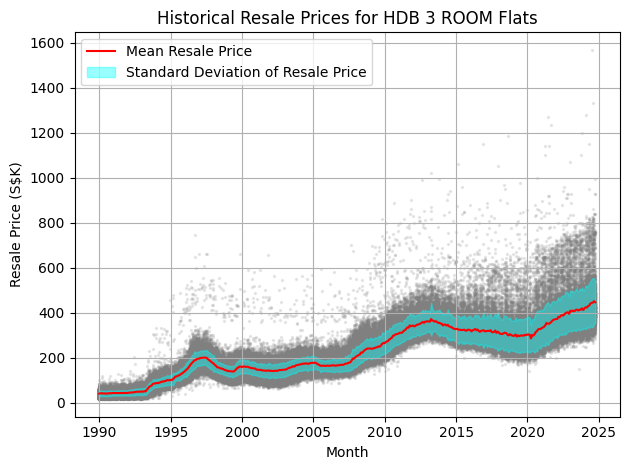


Figures for 3 ROOM Flats as at 1990-01:
Median Resale Price: S$42,000.00
Mean (Average) Resale Price: S$41,445.07
Standard Deviation of Resale Price: S$12,314.90

Figures for 3 ROOM Flats as at 2024-10:
Median Resale Price: S$425,000.00
Mean (Average) Resale Price: S$447,267.31
Standard Deviation of Resale Price: S$92,802.69


In [8]:
x = df_sft['month']
y = df_sft['resale_price']

df_sft_stat = generate_df_stat(x.values, y.values)

# For the upper range of values in the fill range
fill_upp_range = np.subtract(df_sft_stat['mean_resale_price'],
                            df_sft_stat['std_dev'])

# For the lower range of values in the fill range
fill_low_range = np.add(df_sft_stat['mean_resale_price'],
                        df_sft_stat['std_dev'])

# Plot of month and resale_price
plt.scatter(x, y, color='grey', alpha=.15, s=2)

# Plot of mean_resale_price
plt.plot(df_sft_stat['month'],\
            df_sft_stat['mean_resale_price'], \
            'r-', alpha=1, label='Mean Resale Price')

# Generate the fill which includes the standard deviation
plt.fill_between(df_sft_stat['month'], \
                 fill_low_range, \
                 fill_upp_range,
                 alpha=.4, color='cyan', \
                 label='Standard Deviation of Resale Price')


plt.xlabel('Month')
plt.ylabel('Resale Price (S$K)')
plt.title(f'Historical Resale Prices for HDB {selected_flat_type} Flats')
plt.tight_layout()
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


month_list = ['1990-01', '2024-10']

for mth in month_list:

    enc_mth = encode_transaction_month(mth)

    median_resale_price = \
        df_sft_stat['median_resale_price'][df_sft_stat['month']==enc_mth].values[0]
    median_resale_price = median_resale_price * 1000

    mean_resale_price = \
        df_sft_stat['mean_resale_price'][df_sft_stat['month']==enc_mth].values[0]
    mean_resale_price = mean_resale_price * 1000

    std_dev = \
        df_sft_stat['std_dev'][df_sft_stat['month']==enc_mth].values[0]
    std_dev = std_dev * 1000

    print(f'\nFigures for {selected_flat_type} Flats as at {mth}:')
    print(f'Median Resale Price: S${median_resale_price:,.2f}')
    print(f'Mean (Average) Resale Price: S${mean_resale_price:,.2f}')
    print(f'Standard Deviation of Resale Price: S${std_dev:,.2f}')

### VISUALISATION OF HISTORICAL RESALE PRICES (PART 2)

In [9]:
beginning_month_range = range(1990, 2025)

median_value = [df_sft_stat['median_resale_price'][df_sft_stat['month']==mth].values[0] for mth in beginning_month_range]
mean_value = [df_sft_stat['mean_resale_price'][df_sft_stat['month']==mth].values[0] for mth in beginning_month_range]
std_dev_value = [df_sft_stat['std_dev'][df_sft_stat['month']==mth].values[0] for mth in beginning_month_range]
diff = abs(np.subtract(mean_value, median_value))

beginning_month_range = [str(i) + '-01' for i in beginning_month_range]


data = {'month': beginning_month_range,
        'median_S$K': median_value,
        'mean_S$K': mean_value,
        'std_dev_S$K': std_dev_value,
        'diff_mean_and_median_S$K': diff}

df_mean = pd.DataFrame(data)

print(f'Historical Resale Prices for HDB {selected_flat_type} Flats\n\n', df_mean)

Historical Resale Prices for HDB 3 ROOM Flats

       month  median_S$K    mean_S$K  std_dev_S$K  diff_mean_and_median_S$K
0   1990-01      42.000   41.445067    12.314898                  0.554933
1   1991-01      45.500   44.426708    10.572786                  1.073292
2   1992-01      45.500   44.633736    11.284996                  0.866264
3   1993-01      50.000   51.353345    15.385677                  1.353345
4   1994-01      87.000   88.726126    19.230933                  1.726126
5   1995-01     100.000  101.811149    18.629939                  1.811149
6   1996-01     140.000  141.195867    22.001504                  1.195867
7   1997-01     196.000  197.205213    32.506075                  1.205213
8   1998-01     174.000  175.669381    38.546867                  1.669381
9   1999-01     141.000  142.031345    21.393817                  1.031345
10  2000-01     159.000  159.802460    24.495529                  0.802460
11  2001-01     147.900  148.939370    25.888145    

### OBSERVATIONS ON HISTORICAL RESALE PRICES
From the results above, I would say that the median and mean resale prices can be thought of as being *reasonably* close. As such, it would be reasonable to assume a standard normal distribution in the data.<br>

With this assumption, one could say that 68% of the resale prices would be covered by the mean +/- one standard deviation. (Ref: <a href="https://www.mathsisfun.com/data/standard-deviation.html" target="_blank">More info on standard deviation</a>)<br>

Let's take a more concrete example. You can see in the results of the previous section that the mean resale price for Jan 2024 is \$420,369, and the standard deviation \$86,379.

Thus, 68% of the resale prices of 3 ROOM flats in Jan 2024 would fall between **\$333,990** (mean of \$420,369 - standard deviation of \$86,379) and **\$506,748** (mean of \$420,369 + standard deviation of \$86,379).

You can interpret the cyan portion of the graph as the covering 68% of the range of resale prices for the respective month.

### SAMPLE MODEL PREDICTIONS
Here, we will run the resale price predictions on the 1st five records of the test dataset. We will use the deep learning model that we constructed previously, as well as the best-performing Linear Regression and Decision Tree Regression models.

In [16]:
def compare_resale_price_predictions(sample_count,
                                      _X_test,
                                      _X_test_unstd,
                                      _y_test,
                                      model):

    preds_sample = model.predict(_X_test[0:sample_count])

    features = _X_test_unstd[0:sample_count].copy()

    df_sample = pd.DataFrame(features, \
                columns=df_sft_col_names[0:-1])

    df_sample['actual_price_S$K'] = _y_test[0:sample_count]

    df_sample['pred_price_S$K'] = preds_sample

    df_sample['mean_price_S$K'] = \
        [df_train_stat['mean_resale_price'][df_train_stat['month']==mth].values[0] \
         for mth in df_sample['month']]

    df_sample['pred_actual_diff_S$K'] = abs(df_sample['actual_price_S$K'] - \
                                df_sample['pred_price_S$K'])

    df_sample['mean_actual_diff_S$K'] = abs(df_sample['actual_price_S$K'] - \
                                df_sample['mean_price_S$K'])



    df_sample_col_names = df_sample.columns.values.tolist()
    feature_to_index_dict = \
        get_feature_to_index_dict(df_sample_col_names)


    df_sample.iloc[:, feature_to_index_dict['month']] = \
            df_sample['month'].apply(decode_transaction_month)

    df_sample.iloc[:, feature_to_index_dict['storey_range']] = \
            df_sample['storey_range'].apply(decode_storey_range)

    df_sample.iloc[:, feature_to_index_dict['lease_commence_date']] = \
            df_sample['lease_commence_date'].astype(int)

    print(df_sample)


sample_count = 5

# SAMPLE PREDICTION USING PREVIOUSLY SELECTED DEEP LEARNING MODEL ==============
print('SAMPLE PREDICTIONS WITH DEEP LEARNING:\n')
compare_resale_price_predictions(sample_count, \
                                  X_test, \
                                  X_test_unstd, \
                                  y_test, \
                                  dl_model)


# SAMPLE PREDICTION USING LINEAR REGRESSION MODEL ==============================
poly_degree = 7
poly = PolynomialFeatures(degree=poly_degree)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_train_poly, y_train)

print(f'\n\nSAMPLE PREDICTIONS WITH LINEAR REGRESSION (POLYNOMIAL DEGREE OF {poly_degree}):\n')
compare_resale_price_predictions(sample_count, \
                                  X_test_poly, \
                                  X_test_unstd, \
                                  y_test, \
                                  lin_reg_poly)


# SAMPLE PREDICTION USING DECISION TREE REGRESSSION MODEL ======================
tree_depth = 9
tree = DecisionTreeRegressor(max_depth=tree_depth)
tree.fit(X_train_unstd, y_train)

print(f'\n\nSAMPLE PREDICTIONS WITH DECISION TREE REGRESSION (DEPTH OF {tree_depth}):\n')
compare_resale_price_predictions(sample_count, \
                                  X_test_unstd, \
                                  X_test_unstd, \
                                  y_test, \
                                  tree)

SAMPLE PREDICTIONS WITH DEEP LEARNING:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
     month storey_range floor_area_sqm lease_commence_date  actual_price_S$K  \
0  1994-11     01 TO 03           64.0                1987              81.0   
1  2021-10     04 TO 06           82.0                1979             388.0   
2  2016-03     04 TO 06           73.0                1985             290.0   
3  1996-07     22 TO 24           71.0                1972             199.0   
4  1994-01     07 TO 09           67.0                1977              92.0   

   pred_price_S$K  mean_price_S$K  pred_actual_diff_S$K  mean_actual_diff_S$K  
0      101.694656      100.913333             20.694656             19.913333  
1      415.233734      368.326799             27.233734             19.673201  
2      320.499481      320.615003             30.499481             30.615003  
3      154.005554      178.687260             44.994446             20.312740  
4       88.188797       89.122016        

### SUMMARY OF MODEL PERFORMANCES
Deep Learning Model:
>Keras Deep Learning (Final Model) | 3 ROOM | Train Dataset MAE: 27.838<br>
Keras Deep Learning (Final Model) | 3 ROOM | Train Dataset R-squared : 86.28%<br>
Keras Deep Learning (Final Model) | 3 ROOM | Test Dataset MAE: 27.758<br>
Keras Deep Learning (Final Model) | 3 ROOM | Test Dataset R-squared : 86.62%

Linear Regression (Polynomial Degree = 7):
>Linear Regression (Polynomial Degree = 7) | 3 ROOM | Train Dataset MAE: 24.897<br>
Linear Regression (Polynomial Degree = 7) | 3 ROOM | Train Dataset R-squared: 90.47%<br>
Linear Regression (Polynomial Degree = 7) | 3 ROOM | Test Dataset MAE: 24.992<br>
Linear Regression (Polynomial Degree = 7) | 3 ROOM | Test Dataset R-squared: 90.33%

Decision Tree Regression (Depth = 9):
>Decision Tree Regression (Depth = 9) | 3 ROOM | Train Dataset MAE: 21.496<br>
Decision Tree Regression (Depth = 9) | 3 ROOM | Train Dataset R-squared : 91.91%<br>
Decision Tree Regression (Depth = 9) | 3 ROOM | Test Dataset MAE: 21.836<br>
Decision Tree Regression (Depth = 9) | 3 ROOM | Test Dataset R-squared : 91.48%

We can see from the above results that the Decision Tree Regression model performs the best out of the lot. Although the Deep Learning model likely has the potential to offer better performance metrics with a better set of hyperparameters, the time and effort to do so may not make it worth the while in this context.

Considering the historical standard deviation values that we saw earlier, as well as our **Baseline MAE** of $27,158 for the Test dataset, I would say that the metrics from the Decision Tree Regression model show that it offers good performance in capturing the relationship between the 4 most significant features of the flat (i.e. (transaction) month, storey_range, floor_area_sqm, lease_commence_date) and the resale price. In addition, it was easier to tune and runs faster than the Linear Regression and Deep Learning models.

<p style="color:blue">Please include a credit under my GitHub moniker <b>prog4321</b> if you would like use/publish the code and/or the materials above, in part or in its entirety. Thank you!</p>